# Pixelate Club Task 3 COMP9517 20T3

# Import Libraries and Load Image

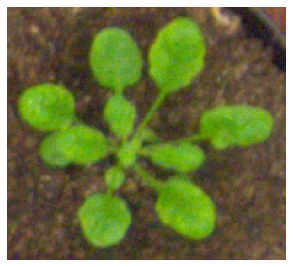

In [1]:
# IMPORT LIBRARY

import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.feature import peak_local_max
from skimage.morphology import watershed

from scipy import ndimage as ndi

# use to colour plant
from plantcv.plantcv import color_palette

# LOAD IMAGE

# read plant and label image

# ara2012
img = cv2.imread("Plant/Ara2012/ara2012_plant004_rgb.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_label = cv2.imread("Plant/Ara2012/ara2012_plant004_label.png")
img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)

# ara2013-canon
#img = cv2.imread("Plant/Ara2013-Canon/ara2013_plant001_rgb.png")
#img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_label = cv2.imread("Plant/Ara2013-Canon/ara2013_plant001_label.png")
#img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)

# tobacco
#img = cv2.imread("Plant/Tobacco/tobacco_plant001_rgb.png")
#img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_label = cv2.imread("Plant/Tobacco/tobacco_plant001_label.png")
#img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)

# get height and width of image
height, width, _ = img.shape

# display image
plt.figure(figsize = (5,5))
plt.axis('off')
plt.imshow(img_rgb)
plt.show()

# Superpixel Segmentation

c:\users\user\pycharmprojects\comp9517\venv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


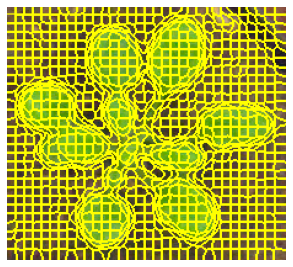

In [2]:
# convert to lab colour space 
img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)

# apply slic - Simple Linear Iterative Clustering
number_of_segments = 1000
# max_iter - no. of iteration
# sigma - width of gaussian filter
segments = slic(img_lab, n_segments = number_of_segments, max_iter = 3, sigma = 3)

img_boundary = mark_boundaries(img_rgb, segments)

# display superpixel image
plt.figure(figsize = (5,5))
plt.axis('off')
plt.imshow(img_boundary)
plt.show()

# Plant Extraction via LAB Colour Space

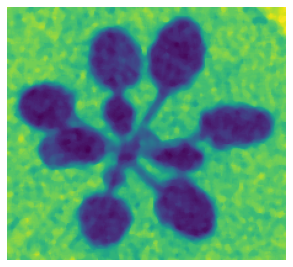

In [3]:
# extract 'a' range of plant
img_lab_a = img_lab[:,:,1]

# contrast stretching
img_lab_a = (img_lab_a - np.min(img_lab_a)) * (255 / (np.max(img_lab_a) - np.min(img_lab_a)))
img_lab_a = img_lab_a.astype(np.uint8)

# median blur to remove minor noise
img_lab_a = cv2.medianBlur(img_lab_a, 5)

# display image
plt.figure(figsize = (5,5))
plt.axis('off')
plt.imshow(img_lab_a)
plt.show()

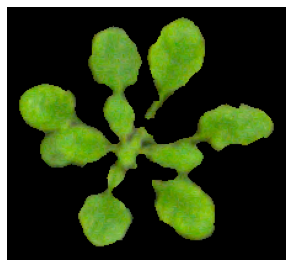

In [4]:
# get mean value of a in lab for each pixel
def mean_colour_a(img):
    
    # if no pixel, return max allowable
    if len(img.flatten()) == 0:
        return 255
        
    return np.mean(img[img > 0], dtype=np.float64)

# black blank image
img_segmented = np.zeros_like(img, np.uint8)

# custom threshold of mean colour of a (a- = green)
threshold = -20

# go thru each segment ID
for segVal in np.unique(segments):
    
    # get all pixel that has same segmented ID
    mask = np.zeros(img_rgb.shape[:2])
    mask[segments == segVal] = 255
    
    # Mask of LAB (for calculation)
    img_lab_mask = np.zeros_like(img_lab_a, np.uint8)
    img_lab_mask[mask > 0] = img_lab_a[mask > 0]
    
    # Mask of RGB (for display)
    img_rgb_mask = np.zeros_like(img, np.uint8)
    img_rgb_mask[mask > 0] = img_rgb[mask > 0]
    
    # Get mean value of "a" of pixels with the same ID
    mean = mean_colour_a(img_lab_mask) - 128
    
    # If below the threshold, it's a plant super pixel
    if mean <= threshold:
        img_segmented += img_rgb_mask
        
# display segmented image
plt.figure(figsize = (5,5))
plt.axis('off')
plt.imshow(img_segmented)
plt.show()

# Watershed Segmentation

c:\users\user\pycharmprojects\comp9517\venv\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.


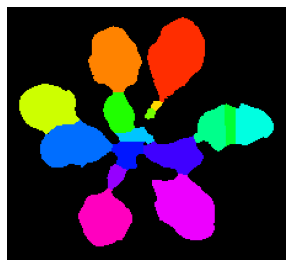

In [10]:
# IMAGE MASK

# convert to binary image for mask
img_gray = cv2.cvtColor(img_segmented, cv2.COLOR_RGB2GRAY)
img_mask = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# FIND LOCAL MAXIMA

# for each labelled pixel, find distance to the nearest background pixel
dist_transform = cv2.distanceTransformWithLabels(img_mask, cv2.DIST_L2, maskSize=0)[0]

# find local maxima
min_distance = 5
localMax = peak_local_max(dist_transform, indices = False, min_distance = min_distance, labels = img_mask)

# WATERSHED SEGMENTATION

# label
markers = ndi.label(localMax, structure=np.ones((3, 3)))[0]
dist_transform1 = -dist_transform
labels = watershed(dist_transform1, markers, mask = img_mask)

# colour image label
img_final =np.zeros_like(img, np.uint8)
for x in np.unique(labels[labels > 0]):
        
    rand_color = color_palette(len(np.unique(labels)))
    img_final[labels == x] = rand_color[x]

# display segmented image
plt.figure(figsize = (5,5))
plt.axis('off')
plt.imshow(img_final)
plt.show()

# Symmetric Best Dice (Metric Evaluation)

In [11]:
def convert_bool(g):
    m = g.copy()
    m[g >0] = True
    m[g == 0] = False
    return m

# Similarity dice measures
# calculate dice
def dice_calc (ground_th, ours):

    numerator = 2 * np.sum(ground_th * ours)
    denominator = np.sum(ground_th) + np.sum(ours)

    dice = float(numerator) / float(denominator)
    
    return dice


# calculate best dice -------
def best_dice (groud_th, ours):

    ground_th_idx = list(set(np.unique(groud_th)).difference([0]))
    ours_idx = list(set(np.unique(ours)).difference([0]))

    best_dice_collect = []
    for i_gt in ground_th_idx:
        
        gt = (groud_th == i_gt).astype('bool')
        
        dice_collect = []
        
        for i_ours in ours_idx:
            
            ors = (ours == i_ours).astype('bool')

            dice = dice_calc(gt, ors)
            
            dice_collect.append(dice)
        

        best_dice = np.max(dice_collect)
        best_dice_collect.append(best_dice)

    best_d = np.mean(best_dice_collect)

    return best_d


# symmetric best dice calculation ----------
def symm_best_dice (ground_th, ours):

    d1 = best_dice(ground_th, ours)
    d2 = best_dice(ours, ground_th)
    
    arr = np.array ([d1, d2])
    symm_best = np.min(arr)
    return symm_best

In [12]:
img_final_bool = convert_bool(img_final)
img_label_bool = convert_bool(img_label)

print("Dice Score:", dice_calc(img_label_bool, img_final_bool))
print("Best Dice Symmetry Score: ", symm_best_dice(img_label_bool, img_final_bool))

Dice Score: 0.7077578933345176
Best Dice Symmetry Score:  0.7077578933345176


# Image Processing Stage

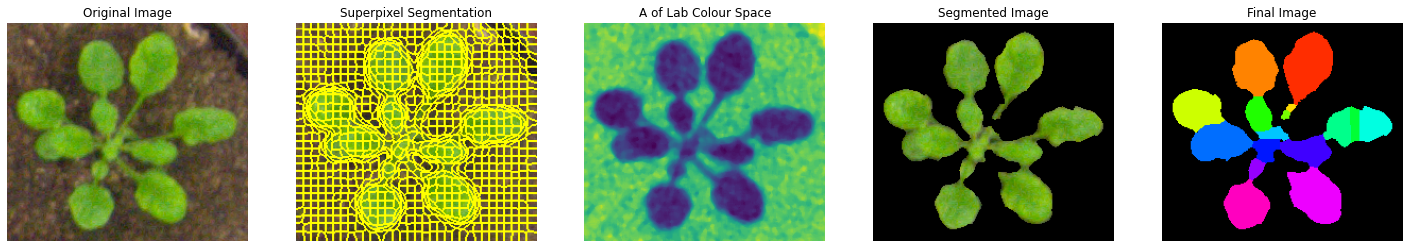

In [13]:
fig = plt.figure(figsize = (25,5))

ax1 = fig.add_subplot(1,5,1)
ax1.title.set_text('Original Image')
ax1.imshow(img_rgb)
ax1.set_axis_off()

ax2 = fig.add_subplot(1,5,2)
ax2.title.set_text('Superpixel Segmentation')
ax2.imshow(img_boundary)
ax2.set_axis_off()

ax3 = fig.add_subplot(1,5,3)
ax3.title.set_text('A of Lab Colour Space')
ax3.imshow(img_lab_a)
ax3.set_axis_off()

ax4 = fig.add_subplot(1,5,4)
ax4.title.set_text('Segmented Image')
ax4.imshow(img_segmented)
ax4.set_axis_off()

ax5 = fig.add_subplot(1,5,5)
ax5.title.set_text('Final Image')
ax5.imshow(img_final)
ax5.set_axis_off()